# Timeseries analysis using LSTM - RNN

## Common imports and functions

In [1]:
# To support both python 2 and python 3
# https://github.com/thushv89/datacamp_tutorials/blob/master/Reviewed/lstm_stock_market_prediction.ipynb
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import datetime as dt
import calendar as cal
import os
import tensorflow as tf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50

/Users/mengwangk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read the stocks historical prices

In [2]:
# !cat ../dataset/5191.csv
df = pd.read_csv('../dataset/5191.csv')
df['date'] = pd.to_datetime(df['date'])
df.info()
df.rename(index=str, columns={'price': 'close'}, inplace=True)
df.drop(['volume','change_percent'], axis=1, inplace=True)
df.sort_values(['date'], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)   # Reset the index starting from 1
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 7 columns):
date              910 non-null datetime64[ns]
price             910 non-null float64
open              910 non-null float64
high              910 non-null float64
low               910 non-null float64
volume            910 non-null object
change_percent    910 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 49.8+ KB


,date,close,open,high,low
0,2015-01-02,1.600,1.620,1.620,1.600
1,2015-01-05,1.530,1.600,1.600,1.520
2,2015-01-06,1.500,1.530,1.530,1.470
3,2015-01-07,1.560,1.500,1.560,1.480
4,2015-01-08,1.670,1.560,1.670,1.560
5,2015-01-09,1.730,1.700,1.750,1.690
6,2015-01-12,1.700,1.720,1.720,1.700
7,2015-01-13,1.680,1.700,1.700,1.680
8,2015-01-14,1.600,1.680,1.680,1.590
9,2015-01-15,1.580,1.620,1.640,1.580


## Pattern over time

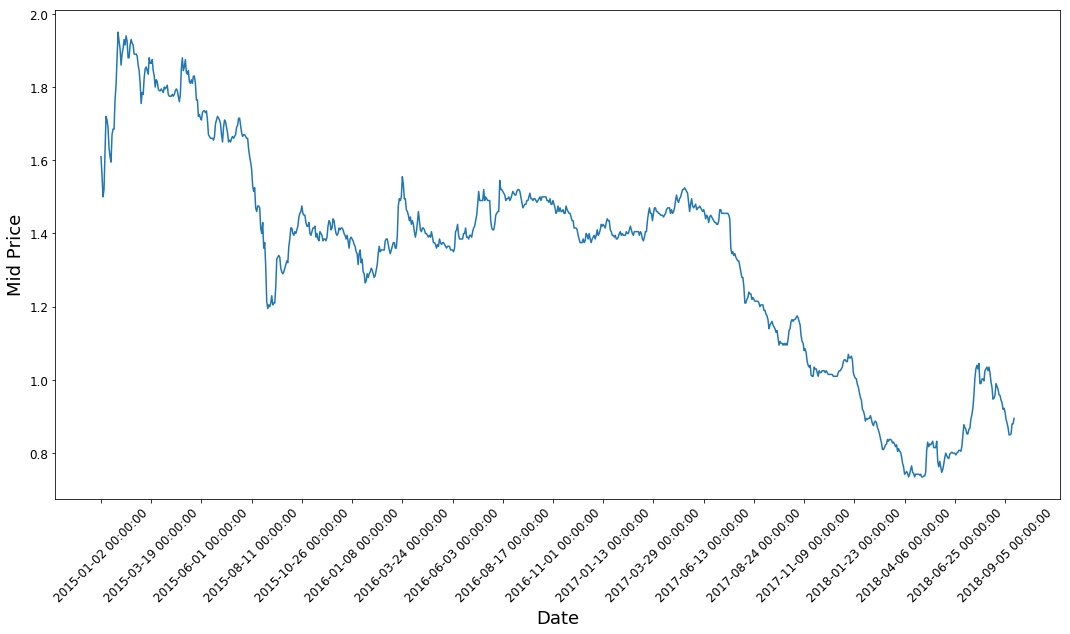

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],50),df['date'].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Split data into training set and a test set

In [4]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'high'].as_matrix()
low_prices = df.loc[:,'low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(mid_prices, test_size=0.2, random_state=42)
display(len(test_data))
display(len(train_data))
display(type(test_data))
display(type(train_data))
display(train_data)
display(test_data)

182

728

numpy.ndarray

numpy.ndarray

array([1.875 , 1.595 , 1.465 , 1.385 , 0.9825, 1.06  , 1.465 , 1.71  ,
       0.7475, 1.415 , 1.915 , 1.82  , 1.49  , 1.475 , 1.45  , 1.52  ,
       1.42  , 1.495 , 1.88  , 1.36  , 1.52  , 0.7925, 1.455 , 0.805 ,
       1.43  , 1.255 , 1.215 , 1.375 , 0.7425, 1.405 , 1.415 , 0.7775,
       0.8175, 0.765 , 0.8325, 1.41  , 1.4   , 1.375 , 1.48  , 1.435 ,
       1.055 , 1.325 , 1.69  , 1.01  , 1.46  , 1.385 , 1.52  , 1.73  ,
       1.46  , 1.04  , 1.42  , 1.45  , 1.01  , 1.0125, 1.055 , 0.965 ,
       1.505 , 1.5   , 1.465 , 1.045 , 1.41  , 0.945 , 1.47  , 1.4   ,
       0.8   , 1.35  , 1.44  , 1.5   , 0.8375, 1.49  , 1.395 , 1.155 ,
       1.4   , 1.39  , 1.495 , 1.435 , 1.165 , 1.415 , 1.78  , 1.61  ,
       1.495 , 1.495 , 1.42  , 1.435 , 0.8   , 1.665 , 1.375 , 1.47  ,
       1.425 , 1.475 , 1.22  , 1.175 , 1.505 , 1.5   , 1.49  , 1.47  ,
       1.21  , 1.46  , 1.515 , 1.49  , 0.735 , 1.82  , 0.795 , 1.29  ,
       1.385 , 0.735 , 1.775 , 1.665 , 0.75  , 0.92  , 1.69  , 1.31  ,
      

array([0.905 , 1.5   , 1.37  , 1.03  , 0.8375, 0.77  , 1.405 , 1.29  ,
       0.85  , 1.025 , 1.405 , 0.88  , 1.78  , 1.665 , 1.46  , 1.015 ,
       1.93  , 1.495 , 1.33  , 1.39  , 1.49  , 1.42  , 1.385 , 1.47  ,
       1.38  , 0.7425, 1.355 , 1.15  , 1.12  , 1.495 , 1.81  , 1.375 ,
       1.405 , 1.01  , 1.365 , 1.22  , 1.345 , 1.93  , 1.375 , 1.4   ,
       1.4   , 1.405 , 1.8   , 1.835 , 1.005 , 1.395 , 1.405 , 1.775 ,
       1.385 , 1.46  , 1.01  , 1.225 , 1.385 , 1.46  , 1.28  , 1.775 ,
       1.715 , 1.695 , 0.8225, 1.45  , 0.8075, 1.85  , 1.02  , 1.405 ,
       1.36  , 1.215 , 1.035 , 1.41  , 0.9475, 1.37  , 1.49  , 0.79  ,
       1.48  , 1.03  , 1.405 , 1.48  , 0.8025, 1.355 , 1.025 , 1.795 ,
       1.47  , 1.455 , 1.365 , 1.695 , 1.805 , 1.395 , 1.32  , 1.455 ,
       1.66  , 1.135 , 1.44  , 1.04  , 1.33  , 1.5   , 1.495 , 1.47  ,
       0.8325, 1.79  , 1.315 , 1.405 , 1.2   , 1.435 , 1.41  , 0.7425,
       1.36  , 1.445 , 0.8925, 1.455 , 1.02  , 1.465 , 1.415 , 1.36  ,
      

### Normalizing the data

In [5]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(len(test_data))
print(len(train_data))

# Train the Scaler with training data and smooth data
smoothing_window_size = 300
for di in range(0,len(train_data),smoothing_window_size):
    # print('fit transform training data')
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
    
# You normalize the last bit of remaining data
# scaler.fit(train_data[di+smoothing_window_size:,:])
# train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)
display(train_data)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
display(test_data)

182
728


array([0.95798319, 0.72268908, 0.61344538, 0.54621849, 0.20798319,
       0.27310924, 0.61344538, 0.81932773, 0.0105042 , 0.57142857,
       0.99159664, 0.91176471, 0.63445378, 0.62184874, 0.60084034,
       0.65966387, 0.57563025, 0.63865546, 0.96218487, 0.52521008,
       0.65966387, 0.04831933, 0.60504202, 0.05882353, 0.58403361,
       0.43697479, 0.40336134, 0.53781513, 0.00630252, 0.56302521,
       0.57142857, 0.03571429, 0.06932773, 0.02521008, 0.08193277,
       0.56722689, 0.55882353, 0.53781513, 0.62605042, 0.58823529,
       0.26890756, 0.49579832, 0.80252101, 0.23109244, 0.6092437 ,
       0.54621849, 0.65966387, 0.83613445, 0.6092437 , 0.25630252,
       0.57563025, 0.60084034, 0.23109244, 0.23319328, 0.26890756,
       0.19327731, 0.64705882, 0.64285714, 0.61344538, 0.2605042 ,
       0.56722689, 0.17647059, 0.61764706, 0.55882353, 0.05462185,
       0.51680672, 0.59243697, 0.64285714, 0.08613445, 0.63445378,
       0.55462185, 0.35294118, 0.55882353, 0.55042017, 0.63865

array([0.14718615, 0.66233766, 0.54978355, 0.25541126, 0.08874459,
       0.03030303, 0.58008658, 0.48051948, 0.0995671 , 0.25108225,
       0.58008658, 0.12554113, 0.9047619 , 0.80519481, 0.62770563,
       0.24242424, 1.03463203, 0.65800866, 0.51515152, 0.56709957,
       0.65367965, 0.59307359, 0.56277056, 0.63636364, 0.55844156,
       0.00649351, 0.53679654, 0.35930736, 0.33333333, 0.65800866,
       0.93073593, 0.55411255, 0.58008658, 0.23809524, 0.54545455,
       0.41991342, 0.52813853, 1.03463203, 0.55411255, 0.57575758,
       0.57575758, 0.58008658, 0.92207792, 0.95238095, 0.23376623,
       0.57142857, 0.58008658, 0.9004329 , 0.56277056, 0.62770563,
       0.23809524, 0.42424242, 0.56277056, 0.62770563, 0.47186147,
       0.9004329 , 0.84848485, 0.83116883, 0.07575758, 0.61904762,
       0.06277056, 0.96536797, 0.24675325, 0.58008658, 0.54112554,
       0.41558442, 0.25974026, 0.58441558, 0.18398268, 0.54978355,
       0.65367965, 0.04761905, 0.64502165, 0.25541126, 0.58008

In [6]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One step ahead prediction via averaging

### Standard Average

In [7]:
window_size = 30    # Previous 60 days
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00160


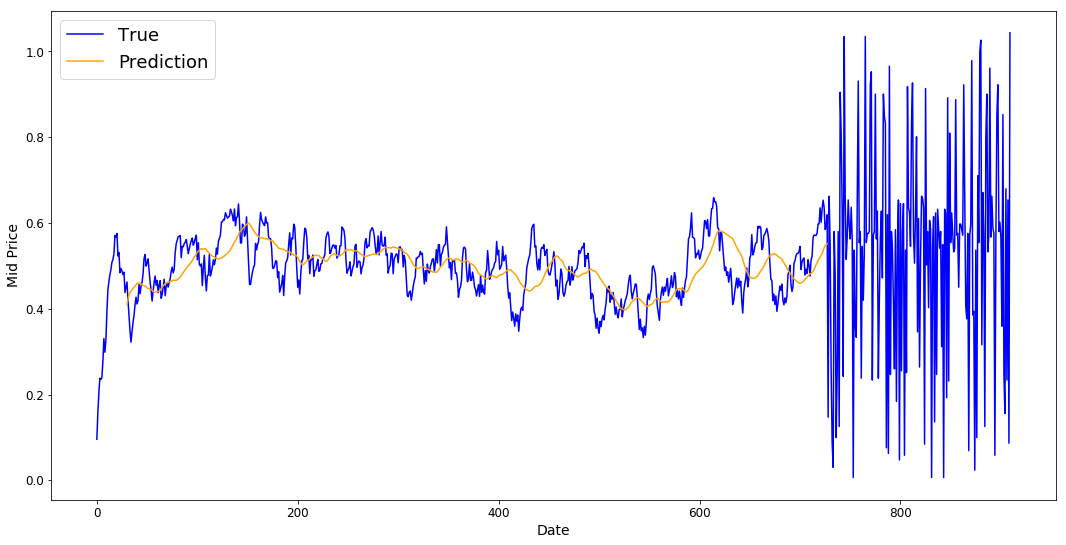

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


### Exponential Moving Average

In [9]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00043


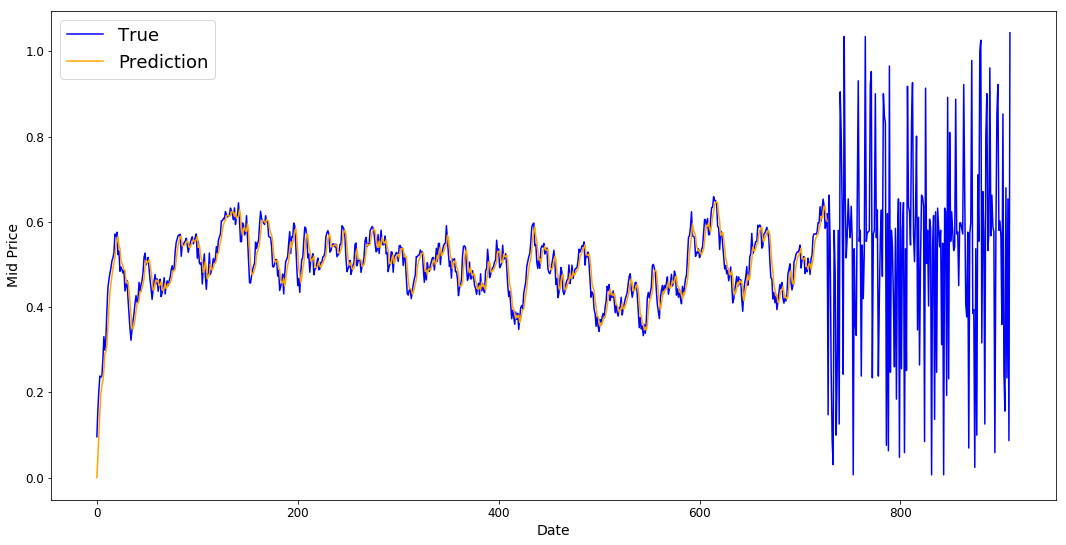

In [10]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### LSTM

#### Data Generator

In [11]:
class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.09579832 0.5534128  0.5249446  0.5527031  0.4749232 ]

	Output: [0.23820673 0.5760118  0.52833253 0.59694934 0.42289186]


Unrolled index 1
	Inputs:  [0.1584874  0.59723115 0.52833253 0.58755624 0.42804816]

	Output: [0.23897685 0.5921299  0.4830623  0.54404455 0.42289186]


Unrolled index 2
	Inputs:  [0.20398319 0.5921299  0.4830623  0.5942327  0.44244498]

	Output: [0.23897685 0.61420894 0.5296524  0.54684174 0.40765852]


Unrolled index 3
	Inputs:  [0.23820673 0.5690514  0.49568042 0.59694934 0.42289186]

	Output: [0.23518437 0.5076983  0.4816235  0.49059612 0.40765852]


Unrolled index 4
	Inputs:  [0.23518437 0.5760118  0.5007342  0.54404455 0.44109648]

	Output: [0.27642372 0.61420894 0.5283678  0.5156106  0.426582  ]


#### Defining hyperparameters

In [12]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

#### Defining inputs and outputs

In [13]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

#### Defining parameters of the LSTM and regression layer

In [14]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))


### Calculate LSTM output and feeding it to the regression layer

In [15]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)


#### Loss calculation and optimizer

In [16]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')


Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


#### Prediction related calculations

In [17]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


#### Running the LSTM

In [18]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(train_data.size,train_data.size + 150 ,50).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          # print(pred_i)
        
          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')


Initialized
Average loss at step 1: 6.510209
	Test MSE: 0.16180
	Finished Predictions
Average loss at step 2: 5.963620
	Test MSE: 0.15602
	Finished Predictions
Average loss at step 3: 5.391634
	Test MSE: 0.14976
	Finished Predictions
Average loss at step 4: 4.732717
	Test MSE: 0.14289
	Finished Predictions
Average loss at step 5: 4.197229
	Test MSE: 0.13521
	Finished Predictions
Average loss at step 6: 3.653934
	Test MSE: 0.12652
	Finished Predictions
Average loss at step 7: 3.120179
	Test MSE: 0.11654
	Finished Predictions
Average loss at step 8: 2.627841
	Test MSE: 0.10503
	Finished Predictions
Average loss at step 9: 2.153862
	Test MSE: 0.09172
	Finished Predictions
Average loss at step 10: 1.645936
	Test MSE: 0.07654
	Finished Predictions
Average loss at step 11: 1.230346
	Test MSE: 0.05984
	Finished Predictions
Average loss at step 12: 0.814094
	Test MSE: 0.04317
	Finished Predictions
Average loss at step 13: 0.406474
	Test MSE: 0.03109
	Finished Predictions
Average loss at step 1

#### Visualizing the LSTM predictions

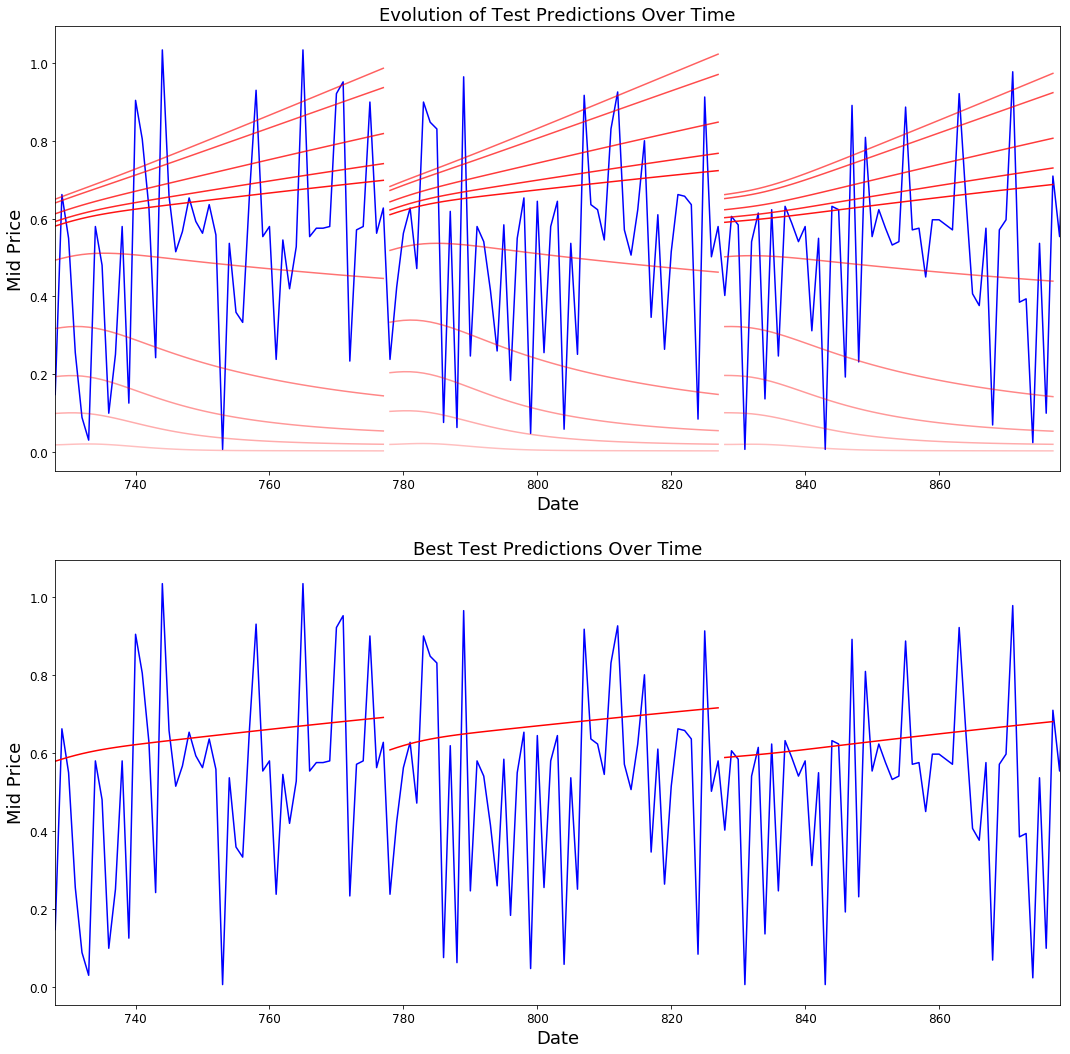

In [23]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(train_data.size,train_data.size + 150)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(train_data.size,train_data.size+150)
plt.show()
